In [1]:
import pandas as pd
import numpy as np
!pip install -U -q PyDrive
from pydrive.drive import GoogleDrive
from google.colab import drive

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# data_path = '/home/arsh/Jasleen/Spring 2023/NLP/Group Project/Authorship-Attribution-for-Neural-Text-Generation-master/data/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data_path = 'drive/MyDrive/Group Project/Authorship-Attribution-for-Neural-Text-Generation-master/data/'
data_path = 'drive/MyDrive/NLP/'

In [7]:
data = pd.read_csv(data_path+'input.csv')
data.tail()

,text,class
11721,how much of your body is your own how much of ...,instructgpt
11722,how do you keep a space station clean how do y...,instructgpt
11723,the city where you pay a years rent up front t...,instructgpt
11724,the bbc news app gives you the best of bbc new...,instructgpt
11725,learn how the bbc is working to strengthen tru...,instructgpt


In [ ]:
# CRNN Model


import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional

# Step 1: Load the data from the CSV file
# data = pd.read_csv('input.csv')
texts = data['text'].tolist()
classes = data['class'].tolist()


# Step 2: Convert the preprocessed text into numerical representations
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 3: Encode the class labels
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(label_encoder.classes_)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_classes, test_size=0.2, random_state=42)

# Step 5: Define and train the CRNN model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=max_sequence_length))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
294/294 [==============================] - 144s 438ms/step - loss: 1.6225 - accuracy: 0.3618 - val_loss: 1.1703 - val_accuracy: 0.5375
Epoch 2/10
294/294 [==============================] - 111s 378ms/step - loss: 0.9712 - accuracy: 0.6170 - val_loss: 0.9198 - val_accuracy: 0.6454
Epoch 3/10
294/294 [==============================] - 109s 369ms/step - loss: 0.6152 - accuracy: 0.7656 - val_loss: 0.9830 - val_accuracy: 0.6445
Epoch 4/10
294/294 [==============================] - 99s 335ms/step - loss: 0.3670 - accuracy: 0.8671 - val_loss: 1.0267 - val_accuracy: 0.6824
Epoch 5/10
294/294 [==============================] - 97s 329ms/step - loss: 0.2073 - accuracy: 0.9328 - val_loss: 1.0064 - val_accuracy: 0.7059
Epoch 6/10
294/294 [==============================] - 95s 322ms/step - loss: 0.0933 - accuracy: 0.9719 - val_loss: 1.1418 - val_accuracy: 0.6965
Epoch 7/10
294/294 [==============================] - 86s 293ms/step - loss: 0.0448 - accuracy: 0.9886 - val_loss: 1.2260 - val

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

# Generate classification report
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))


74/74 [==============================] - 7s 80ms/step
              precision    recall  f1-score   support

        ctrl       0.92      0.96      0.94       214
        fair       0.49      0.67      0.57       209
         gpt       1.00      1.00      1.00       217
        gpt2       0.72      0.45      0.55       213
        gpt3       0.44      0.47      0.46       217
      grover       0.47      0.63      0.54       222
       human       0.70      0.56      0.62       220
 instructgpt       0.72      0.52      0.61       202
        pplm       0.71      0.71      0.71       206
         xlm       0.99      0.97      0.98       215
       xlnet       0.91      0.94      0.93       211

    accuracy                           0.72      2346
   macro avg       0.73      0.72      0.72      2346
weighted avg       0.73      0.72      0.72      2346



In [ ]:
# FastText with parameter tuning


import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load the data from the CSV file
# data = pd.read_csv('input.csv')
texts = data['text'].tolist()
classes = data['class'].tolist()

# Step 2: Tokenize and preprocess the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 3: Convert class labels to numeric values
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(label_encoder.classes_)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_classes,
    test_size=0.2,
    random_state=42
)

# Step 5: Build the FastText model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=max_sequence_length))  # Reduced embedding dimension to 50
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Step 6: Compile and train the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Technique 1: Reduce the batch size
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,  # Reduced batch size to 16
    callbacks=[early_stopping]
)

# Technique 2: Limit the maximum sequence length
max_sequence_length = 100  # Set a smaller maximum sequence length

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_classes,
    test_size=0.2,
    random_state=42
)

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=max_sequence_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

#


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11887, 50)         7556400   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 64)                3264      
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 7,560,379
Trainable params: 7,560,379
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
587/587 [==============================] - 113s 190ms/step - loss: 2.3903 - accuracy: 0.1219 - val_

In [ ]:
from sklearn.metrics import classification_report

# Step 7: Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

# Convert string labels to numeric labels

y_pred = model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred.argmax(axis=-1))
y_pred = label_encoder.transform(y_pred)  # Convert y_pred to numeric values

print(classification_report(y_test, y_pred))


print(classification_report(y_test, y_pred))


Test loss: 0.818
Test accuracy: 0.696
74/74 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       214
           1       0.56      0.47      0.51       209
           2       1.00      0.99      0.99       217
           3       0.52      0.50      0.51       213
           4       0.39      0.47      0.42       217
           5       0.42      0.58      0.49       222
           6       0.74      0.45      0.56       220
           7       0.60      0.72      0.65       202
           8       0.79      0.61      0.69       206
           9       0.95      0.98      0.97       215
          10       0.94      0.93      0.94       211

    accuracy                           0.70      2346
   macro avg       0.71      0.70      0.70      2346
weighted avg       0.71      0.70      0.70      2346

              precision    recall  f1-score   support

           0       0.94      0.96      0.

In [ ]:
# bilstm


import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load the data from the CSV file
# data = pd.read_csv('input.csv')
texts = data['text'].tolist()
classes = data['class'].tolist()

# Step 2: Tokenize and preprocess the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 3: Convert class labels to numeric values
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(label_encoder.classes_)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_classes,
    test_size=0.2,
    random_state=42
)

# Step 5: Build the BiLSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Step 6: Compile and train the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Define mini-batch size
batch_size = 32

# Calculate the number of steps per epoch
steps_per_epoch = len(X_train) // batch_size

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping]
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 11887, 100)        15112800  
                                                                 
 bidirectional_1 (Bidirectio  (None, 11887, 128)       84480     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 11)                715       
                                                                 
Total params: 15,305,067
Trainable params: 15,305,067


In [ ]:
from sklearn.metrics import classification_report

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)


74/74 [==============================] - 37s 483ms/step
              precision    recall  f1-score   support

        ctrl       0.86      0.97      0.91       214
        fair       0.24      0.22      0.23       209
         gpt       0.99      0.98      0.98       217
        gpt2       0.49      0.50      0.50       213
        gpt3       0.27      0.05      0.09       217
      grover       0.40      0.43      0.41       222
       human       0.36      0.56      0.44       220
 instructgpt       0.47      0.70      0.56       202
        pplm       0.86      0.48      0.61       206
         xlm       0.99      0.95      0.97       215
       xlnet       0.84      0.91      0.87       211

    accuracy                           0.61      2346
   macro avg       0.61      0.61      0.60      2346
weighted avg       0.61      0.61      0.60      2346



In [ ]:
# Bilstm with POS tagging


import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load the data from the CSV file
# data = pd.read_csv('input.csv')
texts = data['text'].tolist()
classes = data['class'].tolist()

# Step 2: POS Tagging using NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tags = []
for text in texts:
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    pos_tags.append(" ".join([tag for _, tag in tags]))

# Step 3: Tokenize and preprocess the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 4: Convert class labels to numeric values
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(label_encoder.classes_)

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_classes,
    test_size=0.2,
    random_state=42
)

# Step 6: Build the BiLSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Step 7: Compile and train the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11887, 100)        15112800  
                                                                 
 bidirectional_2 (Bidirectio  (None, 11887, 128)       84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 11)                715       
                                                                 
Total params: 15,305,067
Trainable params: 15,305,067


In [ ]:
# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



74/74 [==============================] - 36s 488ms/step - loss: 1.1732 - accuracy: 0.5895
Test Loss: 1.1731928586959839
Test Accuracy: 0.5895140767097473


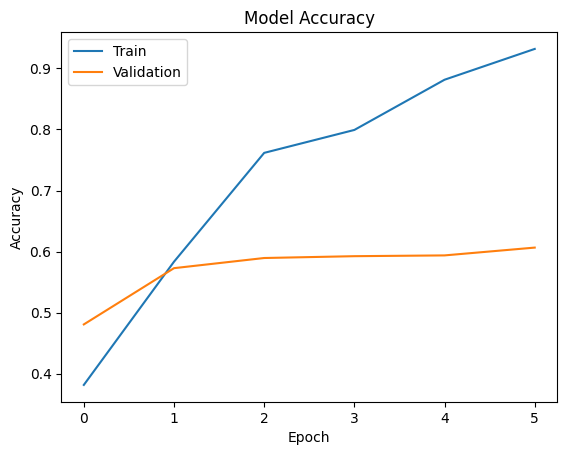

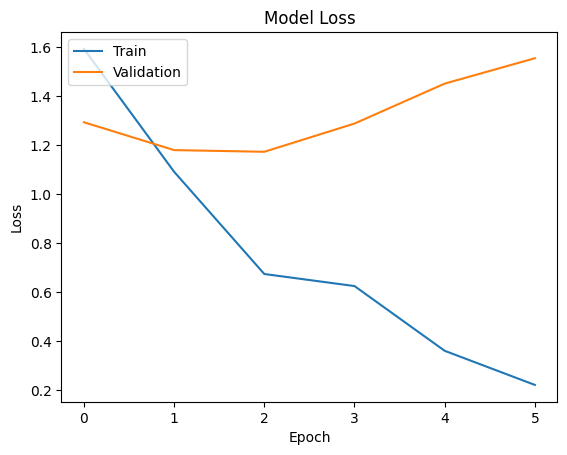

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# distil Bert

!pip install transformers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

# Step 2: Load and preprocess the data
# data = pd.read_csv('input.csv')
X = data['text']
y = data['class']

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Tokenize the sequences
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

# Step 4: Convert the encodings to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train_encodings),
    y_train
)).shuffle(100).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test_encodings),
    y_test
)).batch(16)






Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.7 MB/s eta 0:00:00


In [ ]:
# Step 5: Load and fine-tune the DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
587/587 [==============================] - 618s 1s/step - loss: 0.5537 - accuracy: 0.8374 - val_loss: 0.1758 - val_accuracy: 0.9309
Epoch 2/5
587/587 [==============================] - 585s 996ms/step - loss: 0.1386 - accuracy: 0.9511 - val_loss: 0.1698 - val_accuracy: 0.9395
Epoch 3/5
587/587 [==============================] - 585s 996ms/step - loss: 0.0769 - accuracy: 0.9730 - val_loss: 0.1540 - val_accuracy: 0.9484
Epoch 4/5
587/587 [==============================] - 585s 997ms/step - loss: 0.0380 - accuracy: 0.9869 - val_loss: 0.1398 - val_accuracy: 0.9561
Epoch 5/5
587/587 [==============================] - 585s 996ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.1414 - val_accuracy: 0.9629


In [ ]:
#Save the trained model
model.save_pretrained("/content/drive/MyDrive/distilbert_model")
tokenizer.save_pretrained("/content/drive/MyDrive/distilbert_model")

('/content/drive/MyDrive/distilbert_model/tokenizer_config.json',
 '/content/drive/MyDrive/distilbert_model/special_tokens_map.json',
 '/content/drive/MyDrive/distilbert_model/vocab.txt',
 '/content/drive/MyDrive/distilbert_model/added_tokens.json')

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00


In [ ]:
# Reloading saved model

from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# Reload the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('drive/MyDrive/NLP/distilbert_model')

# Reload the model
model = TFDistilBertForSequenceClassification.from_pretrained('drive/MyDrive/NLP/distilbert_model')


Some layers from the model checkpoint at drive/MyDrive/NLP/distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at drive/MyDrive/NLP/distilbert_model and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import classification_report

# Step 6: Evaluate the model on the test dataset
y_pred = model.predict(test_dataset)
y_pred = tf.argmax(y_pred.logits, axis=-1)

# Step 7: Generate the classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


147/147 [==============================] - 52s 322ms/step
              precision    recall  f1-score   support

        ctrl       1.00      1.00      1.00       214
        fair       0.99      0.95      0.97       209
         gpt       1.00      1.00      1.00       217
        gpt2       0.99      0.99      0.99       213
        gpt3       0.89      0.74      0.81       217
      grover       1.00      0.99      0.99       222
       human       1.00      0.99      0.99       220
 instructgpt       0.77      0.95      0.85       202
        pplm       1.00      1.00      1.00       206
         xlm       0.99      1.00      1.00       215
       xlnet       1.00      1.00      1.00       211

    accuracy                           0.96      2346
   macro avg       0.96      0.96      0.96      2346
weighted avg       0.97      0.96      0.96      2346



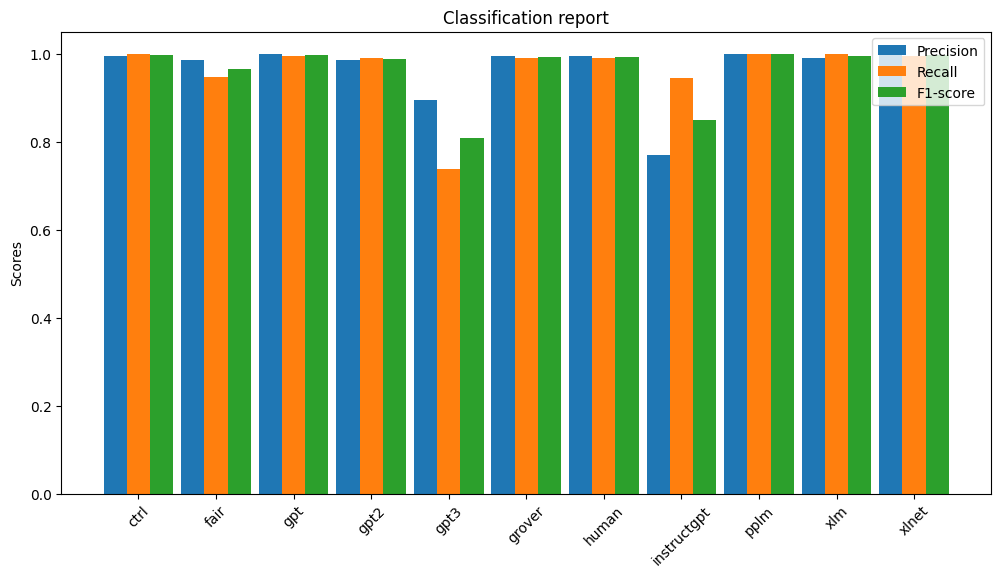

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# # Step 6: Evaluate the model on the test dataset
# y_pred = model.predict(test_dataset)
# y_pred = tf.argmax(y_pred.logits, axis=-1)

# Step 7: Generate the classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Step 8: Plot the classification report as a barplot
labels = list(report.keys())[:-3]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

x = list(range(len(labels))) # convert range object to list
width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar([i - width for i in x], precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar([i + width for i in x], f1_score, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Classification report')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.show()


In [ ]:
# Manually input a text
new_text = input("Enter the text: ")

# Tokenize the input text
new_text_encodings = tokenizer([new_text], truncation=True, padding=True, return_tensors='tf')

# Extract the input IDs and attention mask
input_ids = new_text_encodings['input_ids']
attention_mask = new_text_encodings['attention_mask']

# Predict the class label
predicted_class = tf.argmax(model.predict([input_ids, attention_mask])[0], axis=1).numpy()
predicted_class_label = label_encoder.inverse_transform(predicted_class)[0]

print("Predicted Class:", predicted_class_label)

Enter the text: need help getting my moneyback  if you believe that you have been the victim of a fraudulent or deceptive business practice you should contact your local consumer protection agency and file a complaint depending on the amount of money involved you may also want to contact an attorney for help in recovering your money depending on the circumstances you may be able to file a civil lawsuit against the entity responsible for the fraud additionally the federal trade commission ftc has a number of resources available to help consumers who have been the victims of scams and other deceptive practices back  unfortunately we are unable to provide assistance with getting your money back you may want to contact your bank or financial institution if you believe it was a fraudulent transaction you also have the right to contest a charge with your credit card company if applicable  if you believe you are owed money the first step is to contact the person or entity you believe owes you

In [ ]:
#Distilbert with 10 epochs

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/10
587/587 [==============================] - 635s 1s/step - loss: 0.5458 - accuracy: 0.8364 - val_loss: 0.1899 - val_accuracy: 0.9284
Epoch 2/10
587/587 [==============================] - 637s 1s/step - loss: 0.1381 - accuracy: 0.9459 - val_loss: 0.1285 - val_accuracy: 0.9544
Epoch 3/10
587/587 [==============================] - 637s 1s/step - loss: 0.0725 - accuracy: 0.9730 - val_loss: 0.1777 - val_accuracy: 0.9429
Epoch 4/10
587/587 [==============================] - 602s 1s/step - loss: 0.0447 - accuracy: 0.9850 - val_loss: 0.1155 - val_accuracy: 0.9650
Epoch 5/10
587/587 [==============================] - 602s 1s/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.1148 - val_accuracy: 0.9693
Epoch 6/10
587/587 [==============================] - 602s 1s/step - loss: 0.0200 - accuracy: 0.9930 - val_loss: 0.1638 - val_accuracy: 0.9625
Epoch 7/10
587/587 [==============================] - 602s 1s/step - loss: 0.0088 - accuracy: 0.9969 - val_loss: 0.1053 - val_accuracy: 0.9693

In [ ]:
from sklearn.metrics import classification_report

# Step 6: Evaluate the model on the test dataset
y_pred = model.predict(test_dataset)
y_pred = tf.argmax(y_pred.logits, axis=-1)

# Step 7: Generate the classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


147/147 [==============================] - 53s 329ms/step
              precision    recall  f1-score   support

        ctrl       1.00      1.00      1.00       214
        fair       0.99      0.94      0.97       209
         gpt       1.00      1.00      1.00       217
        gpt2       1.00      0.99      0.99       213
        gpt3       0.86      0.79      0.82       217
      grover       1.00      0.99      0.99       222
       human       0.96      0.99      0.98       220
 instructgpt       0.80      0.90      0.84       202
        pplm       1.00      1.00      1.00       206
         xlm       1.00      1.00      1.00       215
       xlnet       1.00      1.00      1.00       211

    accuracy                           0.96      2346
   macro avg       0.96      0.96      0.96      2346
weighted avg       0.96      0.96      0.96      2346



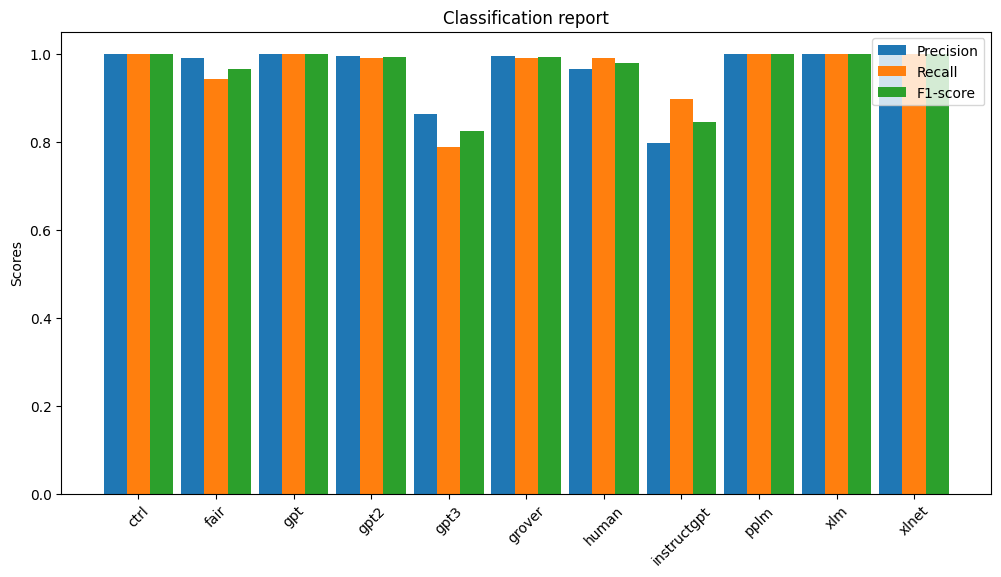

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# # Step 6: Evaluate the model on the test dataset
# y_pred = model.predict(test_dataset)
# y_pred = tf.argmax(y_pred.logits, axis=-1)

# Step 7: Generate the classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Step 8: Plot the classification report as a barplot
labels = list(report.keys())[:-3]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

x = list(range(len(labels))) # convert range object to list
width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar([i - width for i in x], precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar([i + width for i in x], f1_score, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Classification report')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.show()


In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
#Roberta First try

import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder

# Define the dataset class
class NLGDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.label_encoder = LabelEncoder()

        # Encode the class labels
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['class'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data['text'][idx]
        class_label = self.data['encoded_label'][idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'class_label': torch.tensor(class_label).to(device)  # Convert to tensor and move to device
        }



# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the dataset
dataset = NLGDataset(data_path+'input.csv')
# dataset = data

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=11)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['class_label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['class_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item() * input_ids.size(0)
            _, predicted_labels = torch.max(logits, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()

    val_loss /= len(val_dataset)
    val_accuracy = correct_predictions / len(val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Epoch 1/5
Train Loss: 0.5226
Validation Loss: 0.1853
Validation Accuracy: 0.9267
Epoch 2/5
Train Loss: 0.1451
Validation Loss: 0.1484
Validation Accuracy: 0.9425
Epoch 3/5
Train Loss: 0.1005
Validation Loss: 0.1562
Validation Accuracy: 0.9395
Epoch 4/5
Train Loss: 0.0773
Validation Loss: 0.1759
Validation Accuracy: 0.9450
Epoch 5/5
Train Loss: 0.0530
Validation Loss: 0.1968
Validation Accuracy: 0.9322


In [ ]:
# Evaluation on the test set
model.eval()
test_loss = 0.0
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['class_label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item() * input_ids.size(0)
        _, predicted_labels = torch.max(logits, dim=1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(val_dataset)

# Convert the label encodings back to original class labels
test_predictions = label_encoder.inverse_transform(test_predictions)
test_labels = label_encoder.inverse_transform(test_labels)



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 29>:29                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'classification_report' is not defined

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(test_labels, test_predictions)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        ctrl       1.00      1.00      1.00       224
        fair       0.99      0.94      0.96       186
         gpt       1.00      0.99      1.00       199
        gpt2       0.97      0.98      0.98       219
        gpt3       0.62      0.96      0.75       208
      grover       0.97      0.97      0.97       210
       human       0.97      0.93      0.95       227
 instructgpt       0.92      0.52      0.66       230
        pplm       0.99      1.00      1.00       185
         xlm       0.99      1.00      0.99       237
       xlnet       1.00      1.00      1.00       221

    accuracy                           0.93      2346
   macro avg       0.95      0.94      0.93      2346
weighted avg       0.95      0.93      0.93      2346



In [ ]:
# Roberta different parameters

import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder

# Define the dataset class
class NLGDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.label_encoder = LabelEncoder()

        # Encode the class labels
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['class'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data['text'][idx]
        class_label = self.data['encoded_label'][idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'class_label': torch.tensor(class_label).to(device)  # Convert to tensor and move to device
        }



# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the dataset
dataset = NLGDataset(data_path+'input.csv')
# dataset = data

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=11)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['class_label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['class_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item() * input_ids.size(0)
            _, predicted_labels = torch.max(logits, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()

    val_loss /= len(val_dataset)
    val_accuracy = correct_predictions / len(val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch 1/10
Train Loss: 0.4605
Validation Loss: 0.1375
Validation Accuracy: 0.9540
Epoch 2/10
Train Loss: 0.1126
Validation Loss: 0.1025
Validation Accuracy: 0.9591
Epoch 3/10
Train Loss: 0.0788
Validation Loss: 0.1163
Validation Accuracy: 0.9574
Epoch 4/10
Train Loss: 0.0451
Validation Loss: 0.1394
Validation Accuracy: 0.9582
Epoch 5/10
Train Loss: 0.0455
Validation Loss: 0.1171
Validation Accuracy: 0.9621
Epoch 6/10
Train Loss: 0.0326
Validation Loss: 0.1479
Validation Accuracy: 0.9582
Epoch 7/10
Train Loss: 0.0232
Validation Loss: 0.1282
Validation Accuracy: 0.9689
Epoch 8/10
Train Loss: 0.0199
Validation Loss: 0.1348
Validation Accuracy: 0.9659
Epoch 9/10
Train Loss: 0.0240
Validation Loss: 0.1430
Validation Accuracy: 0.9591
Epoch 10/10
Train Loss: 0.0210
Validation Loss: 0.2062
Validation Accuracy: 0.9425


In [10]:
#Roberta Second try

import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder

# Define the dataset class
class NLGDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.label_encoder = LabelEncoder()

        # Encode the class labels
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['class'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data['text'][idx]
        class_label = self.data['encoded_label'][idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids.to(device),
            'attention_mask': attention_mask.to(device),
            'class_label': torch.tensor(class_label).to(device)  # Convert to tensor and move to device
        }



# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the dataset
dataset = NLGDataset(data_path+'input.csv')
# dataset = data

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=11)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['class_label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['class_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item() * input_ids.size(0)
            _, predicted_labels = torch.max(logits, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()

    val_loss /= len(val_dataset)
    val_accuracy = correct_predictions / len(val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Epoch 1/10
Train Loss: 0.5226
Validation Loss: 0.1853
Validation Accuracy: 0.9267
Epoch 2/10
Train Loss: 0.1451
Validation Loss: 0.1484
Validation Accuracy: 0.9425
Epoch 3/10
Train Loss: 0.1005
Validation Loss: 0.1562
Validation Accuracy: 0.9395
Epoch 4/10
Train Loss: 0.0773
Validation Loss: 0.1759
Validation Accuracy: 0.9450
Epoch 5/10
Train Loss: 0.0530
Validation Loss: 0.1968
Validation Accuracy: 0.9322
Epoch 6/10
Train Loss: 0.0409
Validation Loss: 0.2084
Validation Accuracy: 0.9429
Epoch 7/10
Train Loss: 0.0362
Validation Loss: 0.1749
Validation Accuracy: 0.9506
Epoch 8/10
Train Loss: 0.0284
Validation Loss: 0.1926
Validation Accuracy: 0.9425
Epoch 9/10
Train Loss: 0.0253
Validation Loss: 0.2104
Validation Accuracy: 0.9433
Epoch 10/10
Train Loss: 0.0214
Validation Loss: 0.2463
Validation Accuracy: 0.9361


In [13]:
from sklearn.metrics import classification_report

# Evaluation on the test set
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['class_label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, dim=1)
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert the label encodings back to original class labels
test_predictions = dataset.label_encoder.inverse_transform(test_predictions)
test_labels = dataset.label_encoder.inverse_transform(test_labels)

# Generate the classification report
report = classification_report(test_labels, test_predictions)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        ctrl       1.00      1.00      1.00       224
        fair       0.99      0.90      0.94       186
         gpt       0.99      1.00      1.00       199
        gpt2       0.94      0.98      0.96       219
        gpt3       0.68      0.92      0.79       208
      grover       0.99      0.92      0.95       210
       human       0.92      0.98      0.95       227
 instructgpt       0.91      0.63      0.74       230
        pplm       0.99      1.00      1.00       185
         xlm       0.98      1.00      0.99       237
       xlnet       1.00      0.98      0.99       221

    accuracy                           0.94      2346
   macro avg       0.94      0.94      0.94      2346
weighted avg       0.94      0.94      0.94      2346



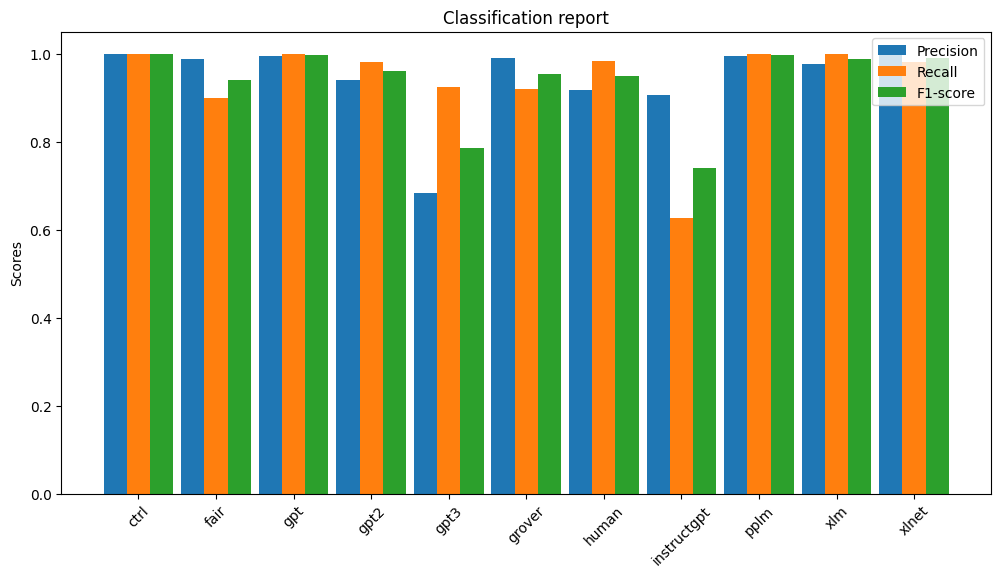

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(test_labels, test_predictions, output_dict=True)

#Plot the classification report as a barplot

labels = list(report.keys())[:-3]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

x = list(range(len(labels))) # convert range object to list
width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar([i - width for i in x], precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar([i + width for i in x], f1_score, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Classification report')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.show()


In [18]:
# Save the trained model
model_path = data_path+'/roberta'
model.save_pretrained(model_path)

# Save the tokenizer
tokenizer_path = data_path+'/roberta'
dataset.tokenizer.save_pretrained(tokenizer_path)

print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.
